# Домашнее задание № 10. Машинный перевод

## Задание 1 (6 баллов + 2 доп балла).
Нужно обучить трансформер на том же корпусе но в другую сторону - с русского на английский.
Можно использовать как основу первый или второй способ реализации (с MultiheadAttention или с nn.Transformer). Подберите несколько тестовых примеров для проверки обучения на каждой эпохе. 

Параметры ниже точно работают в колабе и модель обучается достаточно быстро. Попробуйте их немного увеличить (batch size возможно придется наоборот уменьшить). Обучайте модель хотя бы 5 эпох, а желательно больше, чтобы тестовые примеры начали переводиться более менее адекватно. 

После обучения возьмите хотя бы 100 примером из тестовой части параллельного корпуса и переведите их. Оцените качество переводов с помощью метрики BLEU (пример использования ниже)
Найдите лучшие (как минимум 5) переводы согласно этой метрике и проверьте действительно ли они хорошие. Если все переводы нулевые, то пообучайте модель подольше.

Чтобы получить 2 доп балла вам нужно будет придумать как оптимизировать функцию translate. Сейчас она работает только с одним текстом - это не эффективно. Можно генерировать переводы сразу для нескольких текстов (батча). Главная сложность с таким подходом состоит в том, что генерируемые тексты будут заканчиваться в разное время и нужно сделать столько итераций, сколько нужно для завершения всех текстов (т.е. условие на то, что последний токен не равен [EOS] в текущем коде не сработает). 
ВАЖНО - недостаточно просто изменить входной аргумент с text на texts и добавить еще один цикл по texts! Сама модель должна вызываться на нескольких текстах! Функция с batch prediction должна работать быстрее, поэтому переведите всю тестовую выборку и оцените качество BLEU на всех данных.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer
from tokenizers import decoders

import os
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from collections import Counter

from torchtune.modules import RotaryPositionalEmbeddings
from torch.nn import Transformer
%matplotlib inline

/home/smertlove/sandbox/hse/nlp_hw/compling_nlp_hw/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
text = open('./data/en-ru-train.ru').read().replace('\xa0', ' ')
f = open('./data/en-ru-train.ru', 'w')
f.write(text)
f.close()

<s>Я честно пытался сделать нормально, переписать где-то имена переменных и пр, но постоянно возникала ошибка с тем, что я получал вывод из translate на уровне
"Привет" > "G G G G G G G G G G G G G G G G G G G G G G G G G G G G G G G G G G"
поэтому</s> Теперь модель должна заработать, но я всё равно обучу пару ru-en взяв полностью код из семинара и применив небольшой трюк.
Он заключается в том, чтобы все имена переменных и весь код оставить в неизменном виде и поменять только именя файлов для тренировочных датасетов токенизаторов и модели. Таким образов в en-переменных окажутся токенизатор, сет, векторы, матрицы и пр, связанные с русским языком, а в ru-переменных -- с английским. Просто уже хочется перейти к интересной части домашки, а не заниматься переименовыванием переменных.

In [4]:
en_sents = open('./data/en-ru-train.ru').read().splitlines()  #  <-- Трюк
ru_sents = open('./data/en-ru-train.en').read().splitlines()  #  <-- Трюк

In [ ]:
try:
    tokenizer_en = Tokenizer.from_file("./data/tokenizer_en")
    tokenizer_ru = Tokenizer.from_file("./data/tokenizer_ru")
    print("load existing")
except Exception:
    tokenizer_en = Tokenizer(BPE())
    tokenizer_en.pre_tokenizer = Whitespace()
    trainer_en = BpeTrainer(special_tokens=["[PAD]"], end_of_word_suffix='</w>')
    tokenizer_en.train(
        files=["./data/en-ru-train.ru"],  #  <-- Трюк
        trainer=trainer_en
    )

    tokenizer_ru = Tokenizer(BPE())
    tokenizer_ru.pre_tokenizer = Whitespace()
    trainer_ru = BpeTrainer(special_tokens=["[PAD]", "[BOS]", "[EOS]"], end_of_word_suffix='</w>')
    tokenizer_ru.train(
        files=["./data/en-ru-train.en"],  #  <-- Трюк
        trainer=trainer_ru
    )

    tokenizer_en.decoder = decoders.BPEDecoder()
    tokenizer_ru.decoder = decoders.BPEDecoder()

    tokenizer_en.save('./data/tokenizer_en')
    tokenizer_ru.save('./data/tokenizer_ru')
    print("create new")








create new


In [6]:
def encode(text, tokenizer, max_len, encoder=False):
    if encoder:
        return tokenizer.encode(text).ids[:max_len]
    else:
        return [tokenizer.token_to_id('[BOS]')] + tokenizer.encode(text).ids[:max_len] + [tokenizer.token_to_id('[EOS]')]

In [7]:
# важно следить чтобы индекс паддинга совпадал в токенизаторе с value в pad_sequences
# у нас это в любом случае ноль но лучше safe than sorry
PAD_IDX = tokenizer_ru.token_to_id('[PAD]')
PAD_IDX

0

In [8]:
max_len_en, max_len_ru = 47, 48

In [9]:
X_en = [encode(t, tokenizer_en, max_len_en, encoder=True) for t in en_sents]
X_ru = [encode(t, tokenizer_ru, max_len_ru) for t in ru_sents]

In [10]:
len(X_en), len(X_ru)

(1000000, 1000000)

In [11]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, texts_en, texts_ru):
        self.texts_en = [torch.LongTensor(sent) for sent in texts_en]
        self.texts_en = torch.nn.utils.rnn.pad_sequence(self.texts_en, batch_first=True, padding_value=PAD_IDX)

        self.texts_ru = [torch.LongTensor(sent) for sent in texts_ru]
        self.texts_ru = torch.nn.utils.rnn.pad_sequence(self.texts_ru, batch_first=True, padding_value=PAD_IDX)

        self.length = len(texts_en)

    def __len__(self):
        return self.length

    def __getitem__(self, index):

        ids_en = self.texts_en[index]
        ids_ru = self.texts_ru[index]

        return ids_en, ids_ru

In [12]:
X_en_train, X_en_valid, X_ru_train, X_ru_valid = train_test_split(X_en, X_ru, test_size=0.05)

In [13]:
class TransformerEncoderDecoder(nn.Module):
    def __init__(self, vocab_size_enc, vocab_size_dec, embed_dim, num_heads, ff_dim, num_layers, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.embedding_enc = nn.Embedding(vocab_size_enc, embed_dim)
        self.embedding_dec = nn.Embedding(vocab_size_dec, embed_dim)
        self.positional_encoding = RotaryPositionalEmbeddings(embed_dim // num_heads, max_seq_len=128)

        self.transformer = Transformer(
            d_model=embed_dim,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=ff_dim,
            dropout=dropout,
            batch_first=True
        )

        self.output_layer = nn.Linear(embed_dim, vocab_size_dec)

    def forward(self, src, tgt, src_key_padding_mask=None, tgt_key_padding_mask=None):

        src_embedded = self.embedding_enc(src)
        B,S,E = src_embedded.shape
        src_embedded = self.positional_encoding(src_embedded.view(B,S,self.num_heads, E//self.num_heads)).view(B,S,E)

        tgt_embedded = self.embedding_dec(tgt)
        B,S,E = tgt_embedded.shape
        tgt_embedded = self.positional_encoding(tgt_embedded.view(B,S,self.num_heads, E//self.num_heads)).view(B,S,E)


        tgt_mask = (~torch.tril(torch.ones((S, S), dtype=torch.bool))).to(DEVICE)

        encoder_output = self.transformer.encoder(
            src_embedded,
            src_key_padding_mask=src_key_padding_mask
        )

        decoder_output = self.transformer.decoder(
            tgt_embedded,
            encoder_output,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
            memory_key_padding_mask=src_key_padding_mask
        )

        output = self.output_layer(decoder_output)
        return output

In [14]:
from time import time
def train(model, iterator, optimizer, criterion, scheduler, run=None, print_every=100):

    epoch_loss = []
    ac = []

    model.train()

    for i, (texts_en, texts_ru) in enumerate(iterator):
        texts_en = texts_en.to(DEVICE)
        texts_ru = texts_ru.to(DEVICE)
        texts_ru_input = texts_ru[:,:-1].to(DEVICE)
        texts_ru_out = texts_ru[:, 1:].to(DEVICE)
        src_padding_mask = (texts_en == PAD_IDX).to(DEVICE)
        tgt_padding_mask = (texts_ru_input == PAD_IDX).to(DEVICE)


        logits = model(texts_en, texts_ru_input, src_padding_mask, tgt_padding_mask)
        optimizer.zero_grad()
        B,S,C = logits.shape
        loss = loss_fn(logits.reshape(B*S, C), texts_ru_out.reshape(B*S))
        loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_loss.append(loss.item())

        if not (i+1) % print_every:
            print(f'Loss: {np.mean(epoch_loss)};')
        if run is not None:
            run.log({"loss": loss.item()})

    return np.mean(epoch_loss)


def evaluate(model, iterator, criterion, run=None):

    epoch_loss = []
    epoch_f1 = []

    model.eval()
    with torch.no_grad():
        for i, (texts_en, texts_ru) in enumerate(iterator):
            texts_en = texts_en.to(DEVICE)
            texts_ru = texts_ru.to(DEVICE)
            texts_ru_input = texts_ru[:,:-1].to(DEVICE)
            texts_ru_out = texts_ru[:, 1:].to(DEVICE)
            src_padding_mask = (texts_en == PAD_IDX).to(DEVICE)
            tgt_padding_mask = (texts_ru_input == PAD_IDX).to(DEVICE)

            logits = model(texts_en, texts_ru_input, src_padding_mask, tgt_padding_mask)

            B,S,C = logits.shape
            loss = loss_fn(logits.reshape(B*S, C), texts_ru_out.reshape(B*S))
            epoch_loss.append(loss.item())
            if run is not None:
                run.log({"val_loss": loss.item()})

    return np.mean(epoch_loss)

In [15]:
@torch.no_grad
def translate(text):


    input_ids = tokenizer_en.encode(text).ids[:max_len_en]
    output_ids = [tokenizer_ru.token_to_id('[BOS]')]

    input_ids_pad = torch.nn.utils.rnn.pad_sequence([torch.LongTensor(input_ids)], batch_first=True).to(DEVICE)
    output_ids_pad = torch.nn.utils.rnn.pad_sequence([torch.LongTensor(output_ids)], batch_first=True).to(DEVICE)

    src_padding_mask = (input_ids_pad == PAD_IDX).to(DEVICE)
    tgt_padding_mask = (output_ids_pad == PAD_IDX).to(DEVICE)

    logits = model(input_ids_pad, output_ids_pad, src_padding_mask, tgt_padding_mask)

    pred = logits.argmax(2).item()

    while pred not in [tokenizer_ru.token_to_id('[EOS]'), tokenizer_ru.token_to_id('[PAD]')] and len(output_ids) < 100:
        output_ids.append(pred)
        output_ids_pad = torch.nn.utils.rnn.pad_sequence([torch.LongTensor(output_ids)], batch_first=True).to(DEVICE)
        tgt_padding_mask = (output_ids_pad == PAD_IDX).to(DEVICE)

        logits = model(input_ids_pad, output_ids_pad, src_padding_mask, tgt_padding_mask)
        pred = logits.argmax(2).view(-1)[-1].item()

    return tokenizer_ru.decoder.decode([tokenizer_ru.id_to_token(i) for i in output_ids[1:]])

In [19]:
# попробуйте поставить параметры поменьше если в колабе обучается слишком долго!
vocab_size_enc = tokenizer_en.get_vocab_size()
vocab_size_dec = tokenizer_ru.get_vocab_size()
embed_dim = 256 # еще называется D_MODEL
num_heads = 8
ff_dim = embed_dim*4 # еще называется D_FF
num_layers = 4 # количество слоев

batch_size = 100

# model = TransformerEncoderDecoder(vocab_size_enc,vocab_size_dec, embed_dim, num_heads, ff_dim, num_layers)
model = torch.load("./model", weights_only=False)


In [23]:
training_set = Dataset(X_en_train, X_ru_train)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True, )

valid_set = Dataset(X_en_valid, X_ru_valid)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False)

In [29]:
from matplotlib import pyplot as plt

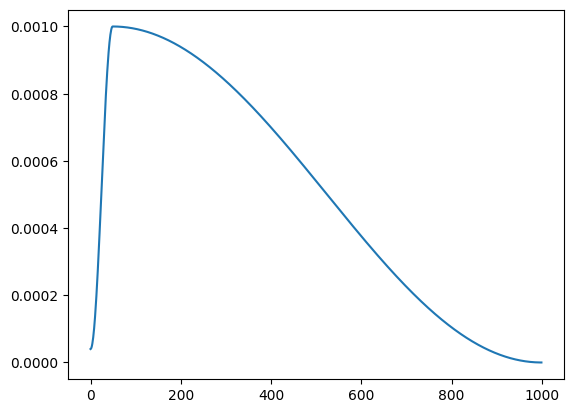

In [30]:
fake_model = torch.nn.Linear(2, 1)
fake_optimizer = torch.optim.AdamW(fake_model.parameters(), lr=0.0001)
fake_scheduler = torch.optim.lr_scheduler.OneCycleLR(fake_optimizer, max_lr=0.001, pct_start=0.05,
                                                steps_per_epoch=50, epochs=20)
lrs = []

for i in range(1000):
    fake_optimizer.step()
    lrs.append(fake_optimizer.param_groups[0]["lr"])
    fake_scheduler.step()

plt.plot(lrs)

In [35]:
model = model.to(DEVICE)
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

NUM_EPOCHS = 20
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, pct_start=0.05,
                                                steps_per_epoch=len(training_generator), epochs=NUM_EPOCHS)

In [25]:
run = None

In [38]:
from timeit import default_timer as timer
NUM_EPOCHS = 20

losses = []

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train(model, training_generator, optimizer, loss_fn, scheduler, run)
    end_time = timer()
    val_loss = evaluate(model, valid_generator, loss_fn, run)

    if not losses:
        print(f'First epoch - {val_loss}, saving model..')
        torch.save(model, 'model')

    elif val_loss < min(losses):
        print(f'Improved from {min(losses)} to {val_loss}, saving model..')
        torch.save(model, 'model')

    losses.append(val_loss)

    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, \
           "f"Epoch time={(end_time-start_time):.3f}s"))

    print(translate("Привет!"))
    print(translate('Как твои дела?'))
    print(translate('Как жена, как дети?'))
    print(translate('съешь же ещё этих мягких французских булок, да выпей чаю'))

Loss: 3.949082534313202;
Loss: 3.9336834275722503;
Loss: 3.9300958863894144;
Loss: 3.9239002269506456;
Loss: 3.9194034538269045;
Loss: 3.915216954151789;
Loss: 3.9115869528906684;
Loss: 3.911065395474434;
Loss: 3.907218619717492;
Loss: 3.9068280210494994;
Loss: 3.904889338883487;
Loss: 3.9033943806091944;
Loss: 3.900322900368617;
Loss: 3.896794419458934;
Loss: 3.891954797744751;
Loss: 3.8883381105959414;
Loss: 3.8856318900164437;
Loss: 3.8836819529533386;
Loss: 3.881686609795219;
Loss: 3.8791058444976807;
Loss: 3.8769428009078615;
Loss: 3.874616386456923;
Loss: 3.870551896095276;
Loss: 3.8671520191431044;
Loss: 3.8651726276397707;
Loss: 3.8622736778626074;
Loss: 3.8593919431721724;
Loss: 3.8565168835435597;
Loss: 3.8545824130650224;
Loss: 3.851439120451609;
Loss: 3.8484368844186108;
Loss: 3.8454179868847134;
Loss: 3.8424059492891485;
Loss: 3.839518458001754;
Loss: 3.8364578933034625;
Loss: 3.834244335691134;
Loss: 3.832266693372984;
Loss: 3.8298862188113363;
Loss: 3.8277087613252494;
L

KeyboardInterrupt: 

### Эпох на самом деле 7

In [ ]:
#  В этот момент он понял, что псё потерял ((
print(translate('Меня всё время спрашивают: знаю ли я Тайлера Дёрдена?'))

_ ч 4 all the time asking Tyler M г


/home/smertlove/sandbox/hse/nlp_hw/compling_nlp_hw/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


In [41]:
text = open('./data/en-ru-test.ru').read().replace('\xa0', ' ')
f = open('./data/en-ru-test.ru', 'w')
f.write(text)
f.close()

In [42]:
en_test_sents = open('./data/en-ru-train.en').read().splitlines()[666:777]  #  <-- Тут теперь настоящие английские предложения
ru_test_sents = open('./data/en-ru-train.ru').read().splitlines()[666:777]  #  <-- А тут русские

In [43]:
len(en_test_sents), len(ru_test_sents)

(111, 111)

In [44]:
en_test_sents[13], ru_test_sents[13]

('These kids are killing me.', 'Эти дети меня убивают.')

In [45]:
translations = []

for ru_, en_ in zip(ru_test_sents, en_test_sents):
    translations.append(
        {
            "inpt": ru_,
            "fact": translate(ru_),
            "expt": en_,
        }
    )

In [46]:
translations[0]

{'inpt': '- Да, хозяин.',
 'fact': '- Yes , the owner .',
 'expt': '- Yes, Master.'}

#### Нужно очистить всё от пунктуации и оставить только слова.

In [52]:
from string import punctuation

In [54]:
def preproc(string):
    translator = string.maketrans("", "", punctuation)
    return string.translate(translator).strip()


In [55]:
for i in range(len(translations)):
    thriplet = translations[i]
    thriplet["fact"] = preproc(thriplet["fact"])
    thriplet["expt"] = preproc(thriplet["expt"])

In [56]:
translations[0]

{'inpt': '- Да, хозяин.', 'fact': 'Yes  the owner', 'expt': 'Yes Master'}

In [58]:
translations[13]

{'inpt': 'Эти дети меня убивают.',
 'fact': 'These kids kill me',
 'expt': 'These kids are killing me'}

In [57]:
import nltk

In [60]:
for i in range(len(translations)):
    thriplet = translations[i]
    fact = thriplet["fact"].lower().split()
    expt = thriplet["expt"].lower().split()
    thriplet["bleu"] = nltk.translate.bleu_score.sentence_bleu([fact], expt, auto_reweigh=True)

/home/smertlove/sandbox/hse/nlp_hw/compling_nlp_hw/.venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/smertlove/sandbox/hse/nlp_hw/compling_nlp_hw/.venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/smertlove/sandbox/hse/nlp_hw/compling_nlp_hw/.venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independen

In [ ]:
translations[13]

({'inpt': 'Эти дети меня убивают.',
  'fact': 'These kids kill me',
  'expt': 'These kids are killing me',
  'bleu': 9.283142785759642e-155},
 111)

In [65]:
sorted(translations, key=lambda d: d["bleu"], reverse=True)[:10]

[{'inpt': 'Держитесь!', 'fact': 'Hold on', 'expt': 'Hold on', 'bleu': 1.0},
 {'inpt': 'Детка...', 'fact': 'Babe', 'expt': 'Babe', 'bleu': 1.0},
 {'inpt': 'Что случилось?',
  'fact': 'What happened',
  'expt': 'What happened',
  'bleu': 1.0},
 {'inpt': 'Все чисто.', 'fact': 'All clear', 'expt': 'All clear', 'bleu': 1.0},
 {'inpt': 'Марси.', 'fact': 'Marcy', 'expt': 'Marcy', 'bleu': 1.0},
 {'inpt': 'И я тебя люблю.',
  'fact': 'I love you',
  'expt': 'I love you',
  'bleu': 1.0},
 {'inpt': 'Хмм.', 'fact': 'Hmm', 'expt': 'Hmm', 'bleu': 1.0},
 {'inpt': 'Хочу выйти за тебя замуж!',
  'fact': 'I want to marry you',
  'expt': 'I want to marry you',
  'bleu': 1.0},
 {'inpt': 'Алан Гарнер.',
  'fact': 'Alan Garner',
  'expt': 'Alan Garner',
  'bleu': 1.0},
 {'inpt': 'Сомали', 'fact': 'Somalia', 'expt': 'Somalia', 'bleu': 1.0}]

### Переводы получились идеальные (с поправкой на пунктуацию и кейс букв) но предложения совсем маленькие. Можно попробовать попереводить что-то длинное.

In [66]:
en_test_sents = open('./data/en-ru-train.en').read().splitlines()  #  <-- Тут теперь настоящие английские предложения
ru_test_sents = open('./data/en-ru-train.ru').read().splitlines()  #  <-- А тут русские

In [68]:
to_translate = []

for i, sent in enumerate(ru_test_sents):
    if len(sent) > 50:
        to_translate.append(i)
    if len(to_translate) == 100:
        break

In [69]:
len(to_translate)

100

In [72]:

translations = []

for i in to_translate:
    ru_ = ru_test_sents[i]
    en_ = en_test_sents[i]
    translations.append(
        {
            "inpt": ru_,
            "fact": preproc(translate(ru_)),
            "expt": preproc(en_),
        }
    )

In [74]:
translations[13]

{'inpt': 'Разумеется, он преступник, но количество его жертв едва ли сравнимо с количеством жертв аварий на дорогах.',
 'fact': 'Of course he  s a criminal  but the number of victims barely matched the victim',
 'expt': 'He committed crimes but traffic causes many more victims than he does'}

In [75]:
for i in range(len(translations)):
    thriplet = translations[i]
    fact = thriplet["fact"].lower().split()
    expt = thriplet["expt"].lower().split()
    thriplet["bleu"] = nltk.translate.bleu_score.sentence_bleu([fact], expt, auto_reweigh=True)

/home/smertlove/sandbox/hse/nlp_hw/compling_nlp_hw/.venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/smertlove/sandbox/hse/nlp_hw/compling_nlp_hw/.venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/smertlove/sandbox/hse/nlp_hw/compling_nlp_hw/.venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independen

In [76]:
translations[13]

{'inpt': 'Разумеется, он преступник, но количество его жертв едва ли сравнимо с количеством жертв аварий на дорогах.',
 'fact': 'Of course he  s a criminal  but the number of victims barely matched the victim',
 'expt': 'He committed crimes but traffic causes many more victims than he does',
 'bleu': 1.0032743411283238e-231}

In [77]:
sorted(translations, key=lambda d: d["bleu"], reverse=True)[:10]

[{'inpt': 'Рассмотрение докладов, представленных государствами-участниками в соответствии со статьей 18 Конвенции (продолжение)',
  'fact': 'Consideration of reports submitted by States parties under Article 18 of the Convention  continued',
  'expt': 'Consideration of reports submitted by States parties under article 18 of the Convention continued',
  'bleu': 1.0},
 {'inpt': 'Посмотрел, если у тебя шанс подумать насчет предложения.',
  'fact': 'I mean  if you had a chance to think about the offer',
  'expt': 'Seeing if you had a chance to think about the offer',
  'bleu': 0.8155395405382073},
 {'inpt': 'У меня есть маленькая проблема с моей карточкой " МаstеrCаrd".',
  'fact': 'I have a little problem with my card  Magog  tab',
  'expt': 'I have a little problem with my MasterCard',
  'bleu': 0.6548907866815301},
 {'inpt': 'В соответствии с обычной практикой я предлагаю, с согласия Совета, пригласить этого представителя для участия в дискуссии без права голоса, согласно соответствующи

### Тут всё уже не так гладко.

In [79]:
translations[11]

{'inpt': 'И у нас остаётся лишь несколько вариантов развития событий.',
 'fact': 'We have just a few development options',
 'expt': 'Leaves us with a couple possibilities',
 'bleu': 9.853445011990208e-232}

### Теперь можно доработать translate
#### Для начала замерим старую

In [87]:
to_translate = ru_test_sents[:100]

In [94]:
min(to_translate)

'!'

In [95]:
max(to_translate, key=len)

'Он призывает государство-участник при осуществлении таких усилий в полной мере использовать общую рекомендацию 19 Комитета и Углубленное исследование Генерального секретаря Организации Объединенных Наций, посвященное всем формам насилия в отношении женщин (A/61/122/Add.1 и Corr.1).'

In [88]:
%%time
for _ in range(10):
    for sent in to_translate:
        translate(sent)

CPU times: user 13min 28s, sys: 108 ms, total: 13min 28s
Wall time: 58 s


#### Теперь можно попробовать пооптимизировать

In [ ]:
@torch.no_grad
def batch_translate(texts):


    input_ids = [
        tokenizer_en.encode(text).ids[:max_len_en]
        for text in texts
    ]

    output_ids = [
        [tokenizer_ru.token_to_id('[BOS]')]
        for text
        in texts
    ]

    input_ids_pads = torch.nn.utils.rnn.pad_sequence(
        [torch.LongTensor(ids) for ids in input_ids],
        batch_first=True
    ).to(DEVICE)

    output_ids_pads = torch.nn.utils.rnn.pad_sequence(
        [torch.LongTensor(ids) for ids in output_ids],
        batch_first=True
    ).to(DEVICE)

    src_padding_mask = (input_ids_pads == PAD_IDX).to(DEVICE)
    tgt_padding_mask = (output_ids_pads == PAD_IDX).to(DEVICE)

    # Идея в том, чтобы на каждом витке вопхать в модель сразу весь многомерный тензор и потом посмотреть, какие предложения закончились
    finished = [False for _ in range(len(texts))]
    logits = model(input_ids_pads, output_ids_pads, src_padding_mask, tgt_padding_mask)
    preds = logits.argmax(2)

    while len(max(output_ids)) < 100 and not all(finished):
        for i in range(len(finished)):
            if not finished[i]:
                item = preds[i].item()
                if item in {tokenizer_ru.token_to_id('[EOS]'), tokenizer_ru.token_to_id('[PAD]')}:
                    finished[i] = True
                else:
                    output_ids[i].append(item)

        output_ids_pads = torch.nn.utils.rnn.pad_sequence(
            [torch.LongTensor(ids) for ids in output_ids],
            batch_first=True
        ).to(DEVICE)
        tgt_padding_mask = (output_ids_pads == PAD_IDX).to(DEVICE)

        logits = model(input_ids_pads, output_ids_pads, src_padding_mask, tgt_padding_mask)
        preds = logits[:, -1, :].argmax(1)  # <-- я не понимаю почему это работает

    return [
        tokenizer_ru.decoder.decode(
            [
                tokenizer_ru.id_to_token(i)
                for i
                in ids[1:]
            ]
        )
        for ids
        in output_ids
    ]

In [206]:
for ru_, en_ in zip(to_translate[10:20], batch_translate(to_translate[10:20])):
    print(ru_, en_, sep="\t")

Я вижу всех этих уродов лгущих тебе.	I can see all these guys .
Ты сказал Дену, что я здесь был?	Did you say that I was here ?
Большинству ваших людей придется остаться на кораблях.	The man you ' re gonna have to stay with the ship .
Потому, прямо сейчас.	Because right now .
И ему понравится то, что мы приготовили.	He ' s gonna like what we have .
Всё что у меня есть.	I ' m all I have .
Нет, нет, нет.	No , no , no .
Липа.	Lip .
- Что там дальше?	- What ' s next ?
Держи меня за руку.	Keep my hand .


In [205]:
%%time
for _ in range(10):
    batch_translate(to_translate)

CPU times: user 1min 33s, sys: 54.9 ms, total: 1min 34s
Wall time: 10.8 s


In [207]:
58 / 10.8

5.37037037037037

### В 5 с лишним раз ускорились
Теперь нужно перевести весь трейнинг датасет

In [209]:
len(ru_test_sents), len(en_test_sents)

(1000000, 1000000)

In [237]:
%%time
translations = []
batchsize = 100

for i in range(0, len(ru_test_sents), batchsize):
    j = i + batchsize

    translations.extend(
        batch_translate(ru_test_sents[i:j])
    )
    torch.cuda.empty_cache()

OutOfMemoryError: CUDA out of memory. Tried to allocate 196.00 MiB. GPU 0 has a total capacity of 7.66 GiB of which 100.81 MiB is free. Including non-PyTorch memory, this process has 7.54 GiB memory in use. Of the allocated memory 6.83 GiB is allocated by PyTorch, and 560.47 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [221]:
len(translations)

5000

In [236]:
torch.cuda.empty_cache()
!nvidia-smi

Thu Mar 20 03:48:59 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.06              Driver Version: 555.42.06      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   45C    P3             12W /   65W |    7743MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



## Задание 2 (2 балла).
Прочитайте главу про машинный перевод у Журафски и Маннига - https://web.stanford.edu/~jurafsky/slp3/13.pdf
Ответьте своими словами в чем заключается техника back translation? Для чего она применяется и что позволяет получить? Опишите по шагам как ее применить к паре en->ru на данных из семинара. Сколько моделей понадобится? Сколько запусков обучения нужно будет сделать?

Ответ должен содержать как минимум 10 предложений.